In [10]:
import keras
import glob
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, transform
from modules.modelarchitecture import get_unet_valid
import re

In [11]:
# The following requires the conda activate tf_cpu environment!
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9240981330733244693
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3204366336
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16863053293567147154
physical_device_desc: "device: 0, name: Quadro M1200, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [4]:
# Sioux Lime Laptop has 8 CPU cores and 1 NVidea Quadro M1200 GPU
import tensorflow as tf
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [14]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

To do and to try:
* pre-process images such that RGB = [0,255] -- > zero mean and unit variance with PCA (Maybe even do this in HSV) (optional)
* Check inputs of RijkZwaan project: Are they [0,255], [0,1], or [-1,1] (important)?
* Is the Loss function correct and applicable here?
* Try to start with only 2 images and overfit: What happens?

# Settings

In [15]:
weight_file = 'unet_membrane.h5'
#weight_file='weights_final_melon.h5'

#image_file= 'IMG_1065_150dpi_TileDL_CP101b4_IL101ji_DLv1_crop.tif'
input_shape=[252,252,3] # rows,cols: must be smaller than size of loaded image, and of shape 16*n+12
#input_shape=[844,844,3]
number_classes=1

# Define Model

In [16]:
# get model
model = get_unet_valid(input_dims=input_shape,nr_classes=number_classes)
model.load_weights(weight_file, by_name = True) # by_name = True prevents an error from the # of classes being different
model.compile(optimizer=keras.optimizers.Adadelta(), loss= 'binary_crossentropy',  metrics=['accuracy']) # values irrelevant since we don't train
# loss= 'categorical_crossentropy' for more than one class, for 1 class use binary_crossentropy (not working)

# Pre-process images

In [17]:
train_filelist = glob.glob("doors/train/*.png")
mask_filelist = glob.glob("doors/train/masks/*.png")
full_filelist = glob.glob("doors/full_dataset/*.png")
testmask = io.imread(mask_filelist[0]) 
testimg = io.imread(train_filelist[0])

In [18]:
# This generates a test set of images that are in the full dataset, but not in the training set.
# Note that also images in the validation set must be excluded if this code becomes serious
Make_Test_set = False

if Make_Test_set:
    all_filelist = glob.glob("doors/full_dataset/*.png")
    all_filelist[0].replace('full_dataset','train')
    #train_filelist[0].replace('doors/train\\','')
    train_filelist[0] == all_filelist[0].replace('full_dataset','train')

    test_filelist = []

    for i in range(len(all_filelist)):
        if np.invert( np.isin(all_filelist[i].replace('full_dataset','train'), train_filelist) ):
            test_filelist.append(all_filelist[i])


In [19]:
Need_rescaling = False

if (Need_rescaling == True):
    for file in train_filelist:
        img = io.imread(file)
        img_reshapedfloat = transform.resize(img, tuple(input_shape[:2]) )
        img_reshaped = ( img_reshapedfloat*255 ).astype(np.uint8) 
        io.imsave(file,img_reshaped)

    for file in mask_filelist:
        img = io.imread(file)
        img_reshapedfloat = transform.resize(img, tuple(input_shape[:2]) )
        img_reshaped = ( img_reshapedfloat*255 ).astype(np.uint8) 
        io.imsave(file,img_reshaped)   
    
    for file in all_filelist:
        img = io.imread(file)
        img_reshapedfloat = transform.resize(img, tuple(input_shape[:2]) )
        img_reshaped = ( img_reshapedfloat*255 ).astype(np.uint8) 
        io.imsave(file,img_reshaped)

In [20]:
# rescaling masks one more time to (68,68), this step is dodgy so take care when looking for bugs:
Mask_Rescaling = False

if Mask_Rescaling==True:
    MaskSize = (68,68)
    for file in mask_filelist:
            img = io.imread(file)
            img_reshapedfloat = transform.resize(img, MaskSize )
            img_reshaped = ( img_reshapedfloat*255 ).astype(np.uint8) 
            io.imsave(file,img_reshaped)  


In [21]:
X = []
for file in train_filelist:
    img = io.imread(file)
    X.append(img)
Y = []
for file in mask_filelist:
    img = io.imread(file)
    img = (img/255).astype(np.uint8)
    Y.append(img)
NumberOfImages = len(X)

X = np.array(X)
Y = np.array(Y)
Y = Y.reshape(Y.shape[0],68,68,1)

In [22]:
model = keras.models.load_model("Rob_test.h5")
model.fit(X, Y, epochs=1, batch_size=20,verbose=1)
model.save("Rob_test.h5")

Epoch 1/1


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1_2/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@train...propFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/Adadelta/gradients/conv2d_1_2/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_1_2/kernel/read)]]
	 [[{{node metrics_3/acc/Mean_1/_2359}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3281_metrics_3/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [18]:
model.save("Doors_Long_run.h5")

# Testing

In [41]:
model = keras.models.load_model("Doors_Long_run.h5")

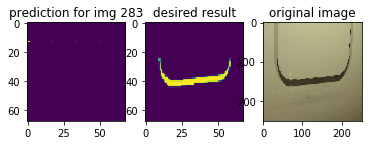

In [44]:
random_index = np.random.randint(len(train_filelist))

#takes random image out of training set
testmask = io.imread(mask_filelist[random_index]) 
testimg = io.imread(train_filelist[random_index])

newtestimg = testimg.reshape((1,252,252,3))

result = model.predict(newtestimg)

#result_resized = transform.resize(result[0,:,:,0], (testimg.shape[0],testimg.shape[1]) ) 

plt.figure(1)
plt.subplot(131)
plt.title('prediction for img '+str(random_index))
plt.imshow(result[0,:,:,0])

plt.subplot(132)
plt.title('desired result')
plt.imshow(testmask)


plt.subplot(133)
plt.title('original image')
plt.imshow(testimg)
""
plt.show()

In [37]:
random_test_index = np.random.randint(len(test_filelist))

testimg = io.imread(test_filelist[random_test_index])
testimg2 = transform.resize(testimg,(68,68,3))
newtestimg = testimg.reshape((1,252,252,3)) 
# be careful with these 252 in case the size of images changes in the future

result = model.predict(newtestimg)

plt.figure(1)
plt.subplot(121)
plt.title('prediction for img '+str(random_test_index))
plt.imshow(result[0,:,:,0])

plt.subplot(122)
plt.title('image '+str(random_test_index))
plt.imshow(testimg2)

NameError: name 'test_filelist' is not defined

# To Do: Merge ground_truth dataset into full_dataset, but avoid duplicates 

In [77]:

#for file in test_filelist:
#    img = io.imread(file)
#    io.imsave(file.replace('full_dataset','test'),img)
    


C:\Users\knoopsr\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:140: UserWarning: doors/test\13572_20180326_171633-134-1.BayerRG12p.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [30]:
ground_filelist = glob.glob('doors/ground_truth/*.png')

In [91]:
fulltest = full_filelist[0][:-17].replace('full_dataset','ground_truth').replace('-','_')

In [92]:
groundtest = ground_filelist[7][:-4]

In [95]:
i=0
for full in full_filelist:
    tempfull = full[:-17].replace('full_dataset','ground_truth').replace('-','_')
    
    for ground in ground_filelist:
        tempground = ground[:-4]
        if tempground == tempfull:
            i+=1
i

87

In [96]:
len(full_filelist), len(ground_filelist)

(350, 2377)